In [1]:
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.model_selection import cross_val_score
from sklearn.svm import SVR
from sklearn.linear_model import LinearRegression
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor

In [2]:
data_path = "../Input/Concrete_Data.csv"
concreto_df = pd.read_csv(data_path)

## A1 - Análise Exploratória dos Dados

A seguir é feita uma analise da disposição dos dados e seus valores juntamente com seu indice de nulidade ou falta dele.

In [3]:
concreto_df.head(10)

,Cement (component 1)(kg in a m^3 mixture),Blast Furnace Slag (component 2)(kg in a m^3 mixture),Fly Ash (component 3)(kg in a m^3 mixture),Water (component 4)(kg in a m^3 mixture),Superplasticizer (component 5)(kg in a m^3 mixture),Coarse Aggregate (component 6)(kg in a m^3 mixture),Fine Aggregate (component 7)(kg in a m^3 mixture),Age (day),"Concrete compressive strength(MPa, megapascals)"
0,540.0,0.0,0.0,162.0,2.5,1040.0,676.0,28,79.99
1,540.0,0.0,0.0,162.0,2.5,1055.0,676.0,28,61.89
2,332.5,142.5,0.0,228.0,0.0,932.0,594.0,270,40.27
3,332.5,142.5,0.0,228.0,0.0,932.0,594.0,365,41.05
4,198.6,132.4,0.0,192.0,0.0,978.4,825.5,360,44.30
5,266.0,114.0,0.0,228.0,0.0,932.0,670.0,90,47.03
6,380.0,95.0,0.0,228.0,0.0,932.0,594.0,365,43.70
7,380.0,95.0,0.0,228.0,0.0,932.0,594.0,28,36.45
8,266.0,114.0,0.0,228.0,0.0,932.0,670.0,28,45.85
9,475.0,0.0,0.0,228.0,0.0,932.0,594.0,28,39.29


In [4]:
new_columns = ["cimento",
            "escória_de_forno",
            "cinza_volante",
            "água",
            "superplastificante",
            "agregado_grosso",
            "agregado_fino",
            "idade",
            "resistencia_compressiva"]
conc_df = concreto_df.copy()
conc_df.columns = new_columns

print("The first 10 rows of the data with new columns names:")
conc_df.head(10)

The first 10 rows of the data with new columns names:


,cimento,escória_de_forno,cinza_volante,água,superplastificante,agregado_grosso,agregado_fino,idade,resistencia_compressiva
0,540.0,0.0,0.0,162.0,2.5,1040.0,676.0,28,79.99
1,540.0,0.0,0.0,162.0,2.5,1055.0,676.0,28,61.89
2,332.5,142.5,0.0,228.0,0.0,932.0,594.0,270,40.27
3,332.5,142.5,0.0,228.0,0.0,932.0,594.0,365,41.05
4,198.6,132.4,0.0,192.0,0.0,978.4,825.5,360,44.30
5,266.0,114.0,0.0,228.0,0.0,932.0,670.0,90,47.03
6,380.0,95.0,0.0,228.0,0.0,932.0,594.0,365,43.70
7,380.0,95.0,0.0,228.0,0.0,932.0,594.0,28,36.45
8,266.0,114.0,0.0,228.0,0.0,932.0,670.0,28,45.85
9,475.0,0.0,0.0,228.0,0.0,932.0,594.0,28,39.29


In [5]:
# The shape of the data
print(f"The number of rows of the data = {conc_df.shape[0]}")
print(f"The number of columns of the data = {conc_df.shape[1]}")

The number of rows of the data = 1030
The number of columns of the data = 9


## A2 - Tratamento dos Dados

É retirado todas as idades do concredo que não sejam o valor de 28 dias e as resistências abaixo de 15Mpa e acima de 50Mpa são retiradas também. Como uma das colunas é preenchida somente com os 28 ela foi retirada.

In [6]:
conc_df.loc[conc_df['idade']!=28,'idade'] = None
conc_df.loc[conc_df['resistencia_compressiva']<15,'resistencia_compressiva'] = None
conc_df.loc[conc_df['resistencia_compressiva']>50,'resistencia_compressiva'] = None
conc_df = conc_df.dropna()
conc_df = conc_df.drop(columns='idade')
conc_df = conc_df.reset_index(drop=True)

In [7]:
# Data Overview
conc_df.tail(10)

,cimento,escória_de_forno,cinza_volante,água,superplastificante,agregado_grosso,agregado_fino,resistencia_compressiva
320,288.4,121.0,0.0,177.4,7.0,907.9,829.5,42.14
321,298.2,0.0,107.0,209.7,11.1,879.6,744.2,31.88
322,264.5,111.0,86.5,195.5,5.9,832.6,790.4,41.54
323,159.8,250.0,0.0,168.4,12.2,1049.3,688.2,39.46
324,166.0,259.7,0.0,183.2,12.7,858.8,826.8,37.92
325,276.4,116.0,90.3,179.6,8.9,870.1,768.3,44.28
326,322.2,0.0,115.6,196.0,10.4,817.9,813.4,31.18
327,148.5,139.4,108.6,192.7,6.1,892.4,780.0,23.70
328,159.1,186.7,0.0,175.6,11.3,989.6,788.9,32.77
329,260.9,100.5,78.3,200.6,8.6,864.5,761.5,32.40


In [8]:
print("Existência de valores faltantes em cada coluna:")
conc_df.isnull().any()

Existência de valores faltantes em cada coluna:


cimento                    False
escória_de_forno           False
cinza_volante              False
água                       False
superplastificante         False
agregado_grosso            False
agregado_fino              False
resistencia_compressiva    False
dtype: bool

In [9]:
conc_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 330 entries, 0 to 329
Data columns (total 8 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   cimento                  330 non-null    float64
 1   escória_de_forno         330 non-null    float64
 2   cinza_volante            330 non-null    float64
 3   água                     330 non-null    float64
 4   superplastificante       330 non-null    float64
 5   agregado_grosso          330 non-null    float64
 6   agregado_fino            330 non-null    float64
 7   resistencia_compressiva  330 non-null    float64
dtypes: float64(8)
memory usage: 20.8 KB


In [10]:
conc_df.describe().T

,count,mean,std,min,25%,50%,75%,max
cimento,330.0,242.688485,87.583380,102.00,159.0000,238.050,304.9500,516.0
escória_de_forno,330.0,89.405455,89.497232,0.00,0.0000,98.900,160.9000,359.4
cinza_volante,330.0,64.537273,65.818305,0.00,0.0000,78.000,118.5250,200.1
água,330.0,186.710606,17.666496,121.80,178.0000,185.700,195.0000,247.0
superplastificante,330.0,6.165152,5.029327,0.00,0.0000,6.950,9.9750,22.1
agregado_grosso,330.0,958.597879,80.994948,801.00,895.2750,959.100,1012.4000,1145.0
agregado_fino,330.0,763.875758,70.814242,594.00,716.5250,769.650,811.2500,945.0
resistencia_compressiva,330.0,32.324939,8.539794,15.09,25.7225,32.645,39.2575,49.9


A matriz das correlações pode ser obitida da seguinte forma

In [11]:
# Correlation between features
matriz_correlacoes = conc_df.corr()
matriz_correlacoes

,cimento,escória_de_forno,cinza_volante,água,superplastificante,agregado_grosso,agregado_fino,resistencia_compressiva
cimento,1.000000,-0.539280,-0.338093,0.067131,-0.227425,0.081895,-0.128402,0.458515
escória_de_forno,-0.539280,1.000000,-0.185896,0.143258,0.014172,-0.242632,-0.324712,0.104717
cinza_volante,-0.338093,-0.185896,1.000000,-0.165770,0.635994,-0.331083,-0.066609,-0.073818
água,0.067131,0.143258,-0.165770,1.000000,-0.369545,-0.326386,-0.417572,-0.119298
superplastificante,-0.227425,0.014172,0.635994,-0.369545,1.000000,-0.359248,0.011727,0.128984
agregado_grosso,0.081895,-0.242632,-0.331083,-0.326386,-0.359248,1.000000,-0.066260,-0.156597
agregado_fino,-0.128402,-0.324712,-0.066609,-0.417572,0.011727,-0.066260,1.000000,-0.237609
resistencia_compressiva,0.458515,0.104717,-0.073818,-0.119298,0.128984,-0.156597,-0.237609,1.000000


Podemos vizualiza-la para melhor entendermos as maiores relaçoes entre os dados.

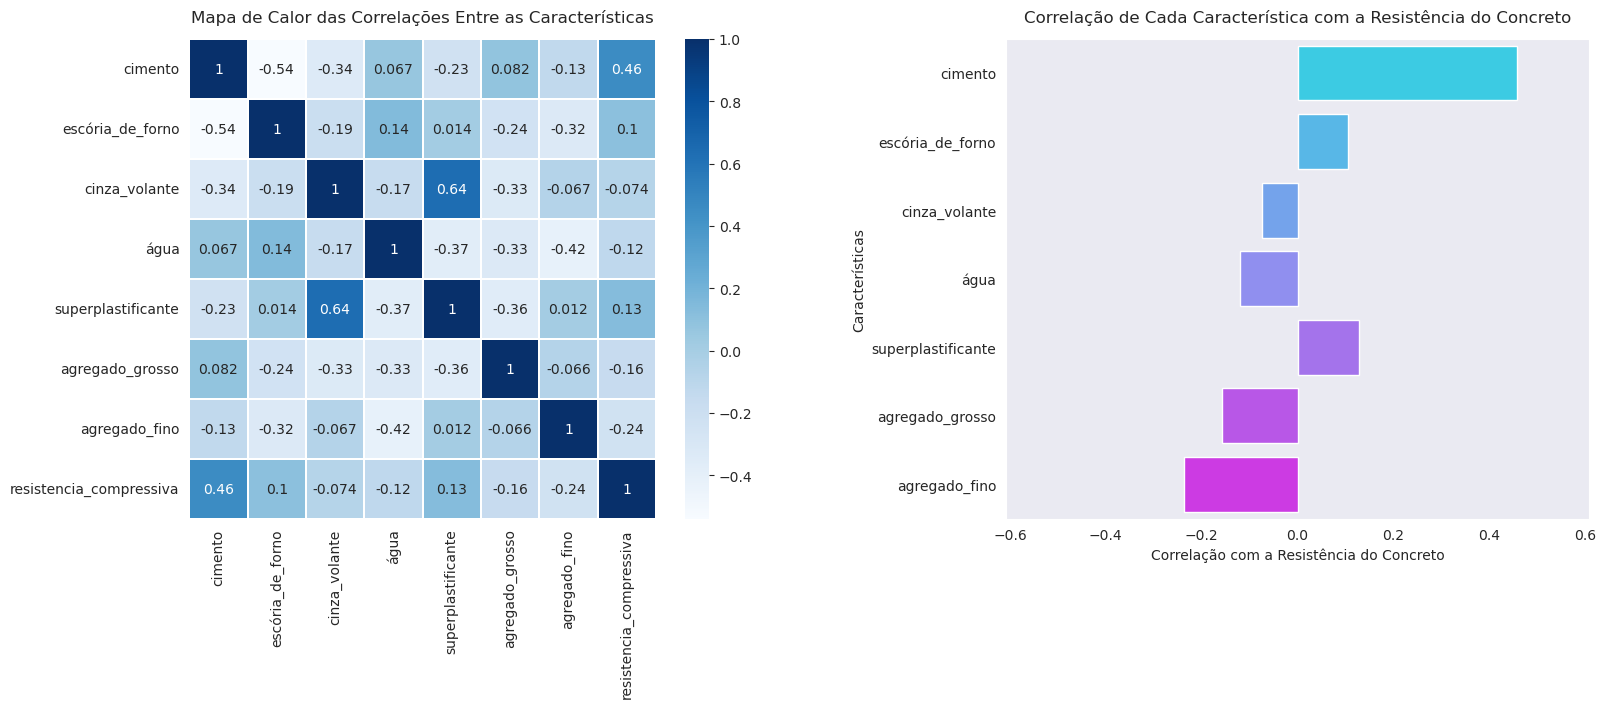

In [12]:
# Visualisation of the Correlations
# Configurações visuais
sns.set_style("dark")

# Criação da figura e da grade para os subplots
figura_correlacao = plt.figure(figsize=(2 * 10, 1 * 6))
grade_subplots = figura_correlacao.add_gridspec(1, 2)
eixos_correlacao = [
    [figura_correlacao.add_subplot(grade_subplots[i, j]) for j in range(2)] for i in range(1)
]

# Representação em Heatmap das correlações
# Heatmap
heatmap_correlacoes = sns.heatmap(matriz_correlacoes,
                                  annot=True,
                                  linewidth=0.1,
                                  cmap="Blues",
                                  ax=eixos_correlacao[0][0])

titulo_heatmap_01 = "Mapa de Calor das Correlações Entre as Características"
titulo_heatmap_02 = "Mapa de Calor das Correlações Entre as Características"
heatmap_correlacoes.set_title(titulo_heatmap_02, pad=12)

# Gráfico de Barras
# A correlação de cada característica com a resistência do concreto
correlacao_com_resistencia = matriz_correlacoes["resistencia_compressiva"][0:-1]
caracteristicas = correlacao_com_resistencia.index

grafico_barras_correlacao = sns.barplot(x=correlacao_com_resistencia, y=caracteristicas, palette="cool",
                                        ax=eixos_correlacao[0][1])
grafico_barras_correlacao.set_title("Correlação de Cada Característica com a Resistência do Concreto", pad=12)
grafico_barras_correlacao.set(xlabel="Correlação com a Resistência do Concreto",
                              ylabel="Características",
                              xlim=(-correlacao_com_resistencia.max() - 0.15, correlacao_com_resistencia.max() + 0.15))

# Ajuste de layout e exibição
plt.subplots_adjust(left=0.1, bottom=0.1, right=0.8, top=0.9, wspace=0.4, hspace=0.4)
plt.show()

## B1 - Preprocessamento

A classe ModelScorer avalia o desempenho de modelos de machine learning utilizados. Ela possui métodos para calcular métricas como R2, RMSE e MAE usando validação cruzada.

In [13]:
class ModelScorer:
    def __init__(self, X, y):
        self.X = X
        self.y = y
        
    
    def __data_criterion(self):
        if isinstance(self.X, pd.core.frame.DataFrame) \
                and isinstance(self.y, pd.core.series.Series):
            return True
        else:
            return False
    
    def cv_single_mae_score(self, model, deviation= False):
        from statistics import mean
        if self.__data_criterion():
            X, y = self.X, self.y
            if deviation == False:
                my_pipeline = Pipeline(
                    steps= [("model", model)]
                )
            else:
                my_pipeline = Pipeline(
                    steps= [("preprocessing", StandardScaler()),
                            ("model", model)]
                )
            mae_scores = -1 * cross_val_score(my_pipeline,
                                              X, y,
                                              cv= 10,
                                              scoring= "neg_mean_absolute_error")
            return mean(mae_scores)
        
    def cv_single_r2_score(self, model, deviation = False):
        from statistics import mean
        if self.__data_criterion():
            X, y = self.X, self.y
            if deviation == False:
                my_pipeline = Pipeline(
                    steps= [("model", model)]
                )
            else:
                my_pipeline = Pipeline(
                    steps= [("preprocessing", StandardScaler()),
                            ("model", model)]
                )
            r2_scores = cross_val_score(my_pipeline,
                                              X, y,
                                              cv= 10,
                                              scoring= "r2")
            return mean(r2_scores)
        
    def cv_single_rmse_score(self, model, deviation = False):
        from statistics import mean
        if self.__data_criterion():
            X, y = self.X, self.y
            if deviation == False:
                my_pipeline = Pipeline(
                    steps= [("model", model)]
                )
            else:
                my_pipeline = Pipeline(
                    steps= [("preprocessing", StandardScaler()),
                            ("model", model)]
                )
            rmse_scores = -1 * cross_val_score(my_pipeline,
                                    X, y,
                                    cv= 10,
                                    scoring= "neg_root_mean_squared_error")
            return mean(rmse_scores)
        
    def cv_collective_score(self, models, model_index): 

        X = self.X
        y = self.y  
        scorer_r2 = self.cv_single_r2_score
        scorer_rmse = self.cv_single_rmse_score
        scorer_mae = self.cv_single_mae_score
        cv_sc_dic = {
            "cv_model_no_scale_R2": [scorer_r2(model) for model in models],
            "cv_model_scaled_R2": [scorer_r2(model, deviation=True) for model in models],
            "cv_model_no_scale_RMSE": [scorer_rmse(model) for model in models],
            "cv_model_scaled_RMSE": [scorer_rmse(model, deviation=True) for model in models],
            "cv_model_no_scale_MAE": [scorer_mae(model) for model in models],
            "cv_model_scaled_MAE": [scorer_mae(model, deviation=True) for model in models]
        }
        cv_sc_df = pd.DataFrame(cv_sc_dic, index= model_index)
        return cv_sc_df

## Aplicação dos modelos utilizados pelo artigo apresentado

In [14]:
models = [SVR(C=1.0,epsilon=0.2),
          XGBRegressor(n_estimators= 500, learning_rate= 0.01, n_jobs= 6),
          LinearRegression(n_jobs= 6),
          KNeighborsRegressor(p= 1, n_jobs= 6),
          KNeighborsRegressor(p= 2, n_jobs= 6),
          RandomForestRegressor(n_estimators= 500, n_jobs= 6)]
model_index = [
               "SVR",
               "XGB_Regression",
               "Linear_Regression",
               "KN_Regression_Taxicab",
               "KN_Regression_Euclidean",
               "Random_Forest_Regression",
               ]
X = conc_df.drop(columns= ["resistencia_compressiva"])
y = conc_df.resistencia_compressiva
model_eval = ModelScorer(X, y)
model_cv_sc_df = model_eval.cv_collective_score(models, model_index)

A comparação entre as medidas de desempenho podem ser visualizadas da seguinte forma:

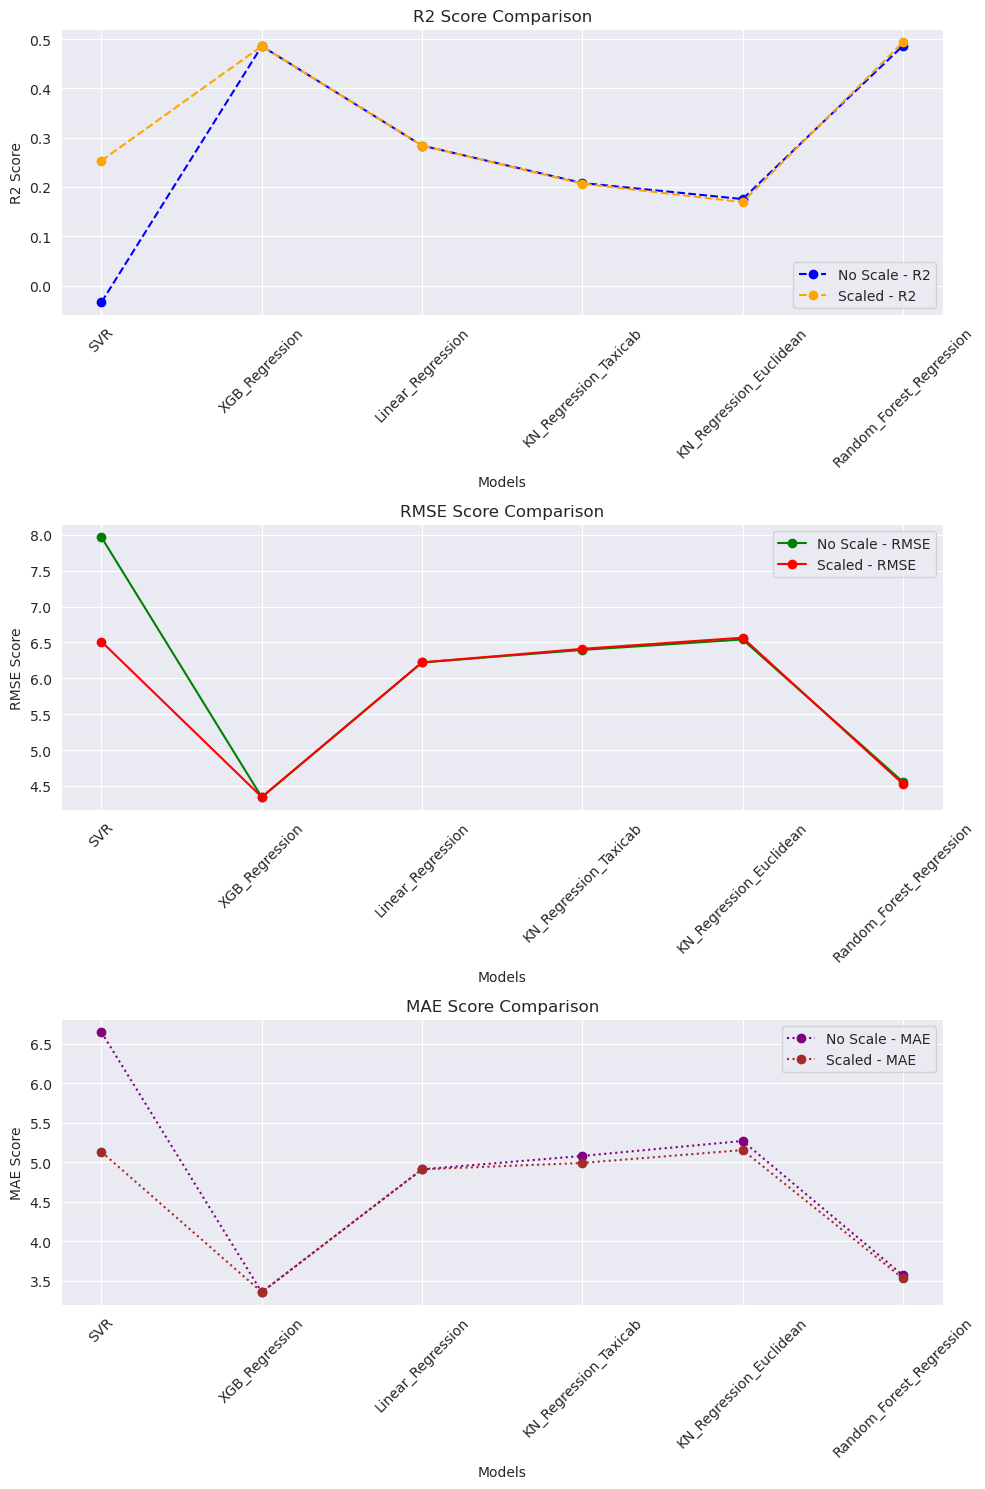

In [15]:
plt.figure(figsize=(10, 15))
    
# Plotting R2 scores in a separate subplot
plt.subplot(3, 1, 1)
plt.plot(model_cv_sc_df.index, model_cv_sc_df['cv_model_no_scale_R2'], 
        marker='o', linestyle='--', label='No Scale - R2', color='blue')
plt.plot(model_cv_sc_df.index, model_cv_sc_df['cv_model_scaled_R2'], 
        marker='o', linestyle='--', label='Scaled - R2', color='orange')
plt.xlabel('Models')
plt.ylabel('R2 Score')
plt.title('R2 Score Comparison')
plt.legend()
plt.xticks(rotation=45)
plt.grid(True)

# Plotting RMSE scores in a separate subplot
plt.subplot(3, 1, 2)
plt.plot(model_cv_sc_df.index, model_cv_sc_df['cv_model_no_scale_RMSE'], 
        marker='o', linestyle='-', label='No Scale - RMSE', color='green')
plt.plot(model_cv_sc_df.index, model_cv_sc_df['cv_model_scaled_RMSE'], 
        marker='o', linestyle='-', label='Scaled - RMSE', color='red')
plt.xlabel('Models')
plt.ylabel('RMSE Score')
plt.title('RMSE Score Comparison')
plt.legend()
plt.xticks(rotation=45)
plt.grid(True)

# Plotting MAE scores in a separate subplot
plt.subplot(3, 1, 3)
plt.plot(model_cv_sc_df.index, model_cv_sc_df['cv_model_no_scale_MAE'], 
        marker='o', linestyle=':', label='No Scale - MAE', color='purple')
plt.plot(model_cv_sc_df.index, model_cv_sc_df['cv_model_scaled_MAE'], 
        marker='o', linestyle=':', label='Scaled - MAE', color='brown')
plt.xlabel('Models')
plt.ylabel('MAE Score')
plt.title('MAE Score Comparison')
plt.legend()
plt.xticks(rotation=45)
plt.grid(True)

plt.tight_layout()
plt.show()

## D3. Otimização do Modelo

Foi notado que o modelo XGB_Regression teve o melhor desempenho, abaixo é feito um teste para testar se ao variar a numero de arvores de decisão pode se conseguir um melhor desempenho nesse modelo, é feito um step de 100 partindo de 100 a 1000.

In [16]:
pos_nest = [k for k in range(100, 1000, 100)]
mod_opt_dic = {"XGBR_no_scale": [model_eval.cv_single_mae_score(
                   XGBRegressor(n_estimators= k,learning_rate= 0.01,n_jobs= 6))
                    for k in pos_nest],
               "XGBR_scaled": [model_eval.cv_single_mae_score(
                   XGBRegressor(n_estimators= k,learning_rate= 0.01,n_jobs= 6),
                   deviation= True)
                    for k in pos_nest]}
mod_opt_df = pd.DataFrame(mod_opt_dic, index= pos_nest)

In [17]:
print("The Model MAE score based on the number of estimators:")
mod_opt_df

The Model MAE score based on the number of estimators:


,XGBR_no_scale,XGBR_scaled
100,12.184249,12.185489
200,5.783855,5.784461
300,3.998965,4.000070
400,3.546004,3.547332
500,3.354436,3.355828
600,3.250503,3.251954
700,3.158921,3.160372
800,3.097602,3.099055
900,3.053086,3.054618


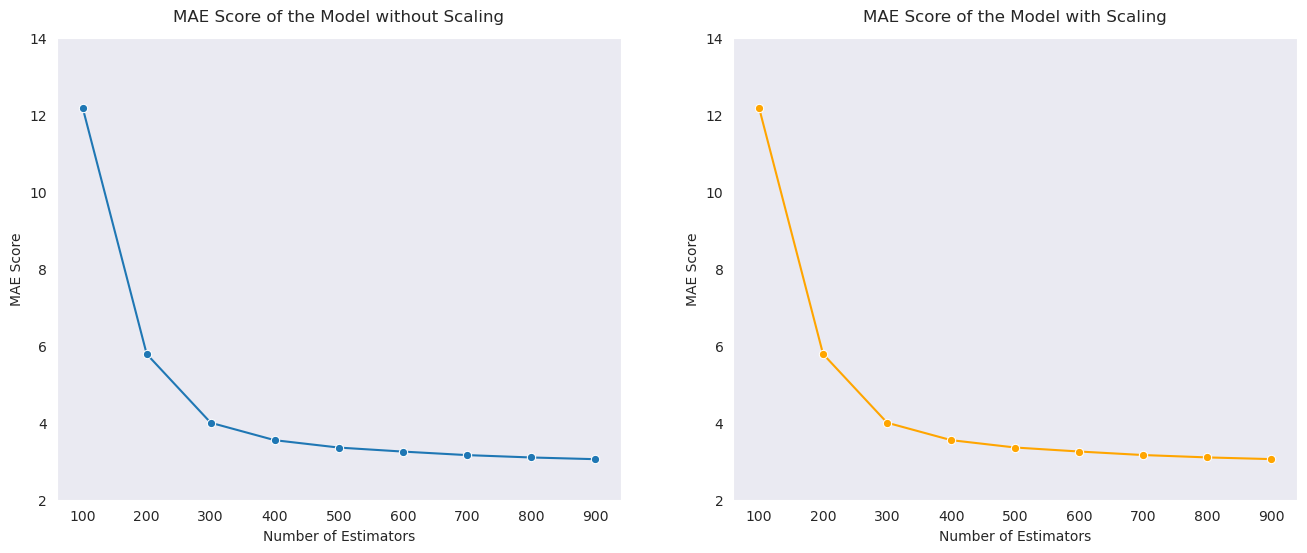

In [18]:
# Model MAE Score Visualisation
sns.set_style("dark")
xgb_fig = plt.figure(figsize= (2 *8, 6))
xgb_gs = xgb_fig.add_gridspec(1, 2)
xgb_ax = [[xgb_fig.add_subplot(xgb_gs[0, j]) for j in range(2)]]

xgb_ax_00 = sns.lineplot(data= mod_opt_df["XGBR_no_scale"],
                         marker= "o",
                         ax= xgb_ax[0][0])
xgb_ax_00.set_title("MAE Score of the Model without Scaling", pad= 12)
xgb_ax_00.set(xlabel= "Number of Estimators",
              ylabel= "MAE Score",
              ylim= (2, 14))

xgb_ax_01 = sns.lineplot(data= mod_opt_df["XGBR_scaled"],
                         marker= "o",
                         color= "orange",
                         ax= xgb_ax[0][1])
xgb_ax_01.set_title("MAE Score of the Model with Scaling", pad= 12)
xgb_ax_01.set(xlabel= "Number of Estimators",
              ylabel= "MAE Score",
              ylim= (2, 14))

plt.show()

Após essa verificação é claro que há um ganho de performance significativo a partir de 400 arvores de decisão, porém após 600 o aumento do desempenho cai não sendo mais viável acrecentar mais arvores.

In [19]:
final_model = XGBRegressor(n_estimators= 600, learning_rate= 0.01, n_jobs= 6)
final_model.fit(X, y)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.01, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             n_estimators=600, n_jobs=6, num_parallel_tree=None, predictor=None,
             random_state=None, ...)

In [20]:
# Actual Data vs Prediction Comparison
final_df = conc_df.copy()
y_pred = final_model.predict(X)
final_df["res_comp_predita"] = y_pred
final_df["dif_predita"] = final_df["resistencia_compressiva"] - final_df["res_comp_predita"]

print("The data embedded with the predicted strength:")
final_df

The data embedded with the predicted strength:


,cimento,escória_de_forno,cinza_volante,água,superplastificante,agregado_grosso,agregado_fino,resistencia_compressiva,res_comp_predita,dif_predita
0,380.0,95.0,0.0,228.0,0.0,932.0,594.0,36.45,36.854862,-0.404862
1,266.0,114.0,0.0,228.0,0.0,932.0,670.0,45.85,43.893093,1.956907
2,475.0,0.0,0.0,228.0,0.0,932.0,594.0,39.29,38.565720,0.724280
3,198.6,132.4,0.0,192.0,0.0,978.4,825.5,28.02,28.419579,-0.399579
4,304.0,76.0,0.0,228.0,0.0,932.0,670.0,47.81,43.916779,3.893221
...,...,...,...,...,...,...,...,...,...,...
325,276.4,116.0,90.3,179.6,8.9,870.1,768.3,44.28,43.905228,0.374772
326,322.2,0.0,115.6,196.0,10.4,817.9,813.4,31.18,31.992155,-0.812155
327,148.5,139.4,108.6,192.7,6.1,892.4,780.0,23.70,24.888540,-1.188540
328,159.1,186.7,0.0,175.6,11.3,989.6,788.9,32.77,33.050583,-0.280583


As correlações entre a força predita e a força real pode ser visualizada da seguinte forma.

In [21]:
def comparacao_real_predito(dataframe, coluna_real, coluna_predita, colunas_hue,
                            titulo_viz1= "Força Real e Força Predita",
                            xlabel_viz1= "Força Real (MPa)",
                            ylabel_viz1= "Força Predita (MPa)",
                            titulo_viz2= "Diferença entre Real e Predito",
                            xlabel_viz2= "Força Real (MPa)",
                            ylabel_viz2= "Diferença (MPa)"):
    
    num_linhas, num_cols = len(colunas_hue), 2
    
    # Criação da figura e dos eixos
    figura_final = plt.figure(figsize=(num_cols * 8, num_linhas * 8))
    grade_figura = figura_final.add_gridspec(num_linhas, num_cols)
    eixos_figura = [[figura_final.add_subplot(grade_figura[i, j]) for j in range(num_cols)] 
                    for i in range(num_linhas)]
    
    # Iteração sobre cada coluna de hue
    for num_row, hue_col in zip(range(num_linhas), colunas_hue):
        # Gráfico de dispersão 1: Real vs. Predito
        scatter1 = sns.scatterplot(x=coluna_real, y=coluna_predita, hue=hue_col, data=dataframe,
                                   palette="cool", ax=eixos_figura[num_row][0])
        scatter1.set_title(titulo_viz1, pad=12)
        scatter1.set(xlabel=xlabel_viz1, ylabel=ylabel_viz1)
        
        # Gráfico de dispersão 2: Diferença entre Real e Predito
        scatter2 = sns.scatterplot(x=coluna_real, y=dataframe[coluna_real] - dataframe[coluna_predita],
                                   hue=hue_col, data=dataframe, palette="cool", ax=eixos_figura[num_row][1])
        scatter2.set_title(titulo_viz2, pad=12)
        scatter2.set(xlabel=xlabel_viz2, ylabel=ylabel_viz2)
    
    plt.subplots_adjust(hspace=0.3)
    plt.show()

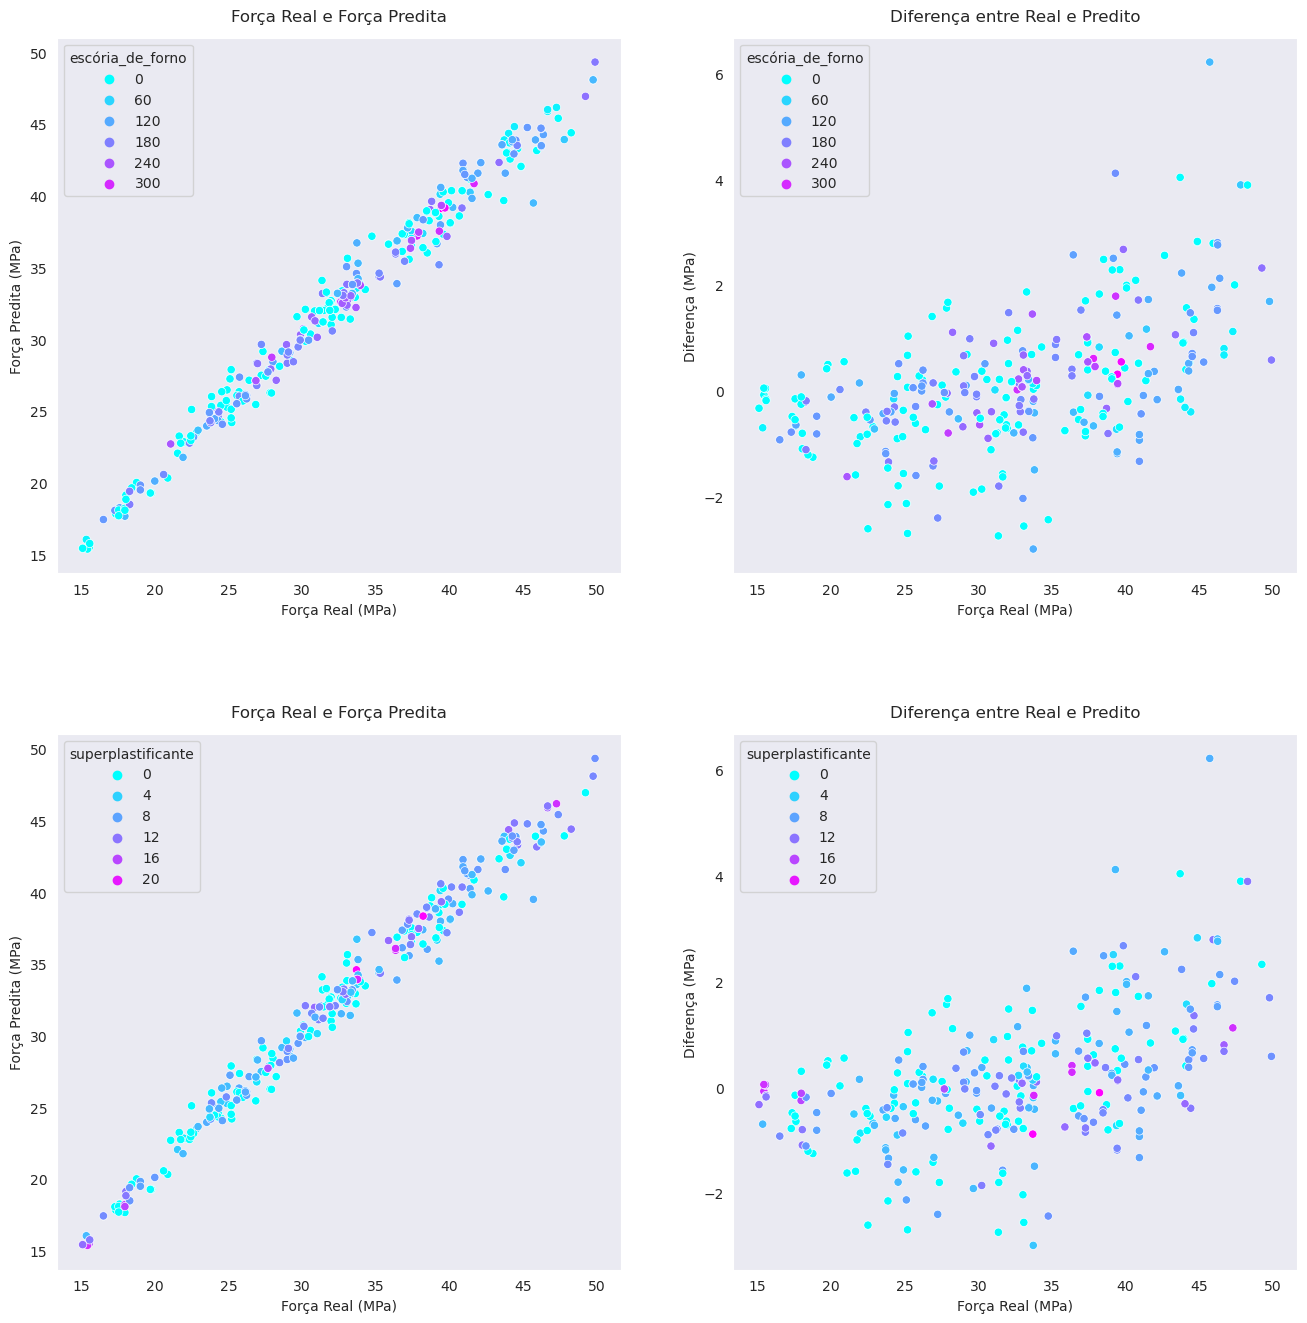

In [24]:
hue_columns = ["escória_de_forno","superplastificante"]
comparacao_real_predito(final_df,
                             "resistencia_compressiva",
                             "res_comp_predita",
                             hue_columns)